#                        <h1 style="color:orange"> SMS Classifier Model

 <h1 style="color:darkblue">Introduction

<b><p style='color:black'>Welcome to the Bharat Intern for the SMS Classifier Model! In this notebook presents a step-by-step guide to building an efficient SMS spam classification model using the SMS Spam Collection dataset. By the end of this notebook, you'll have a powerful tool to help you filter out unwanted messages and ensure that your text messaging experience is smoother and safer.

<h1 style="color:darkblue">Problem Statement

<b><p style='color:black'>The primary goal of this notebook is to develop a predictive model that accurately classifies incoming SMS messages as either ham or spam. We will use the SMS Spam Collection dataset, which consists of 5,574 SMS messages tagged with their respective labels.

<h1 style="color:darkblue">Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize,sent_tokenize
from string import punctuation
from unidecode import unidecode
from nltk.corpus import stopwords
import contractions
import yake
from rake_nltk import Rake
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from nltk.util import ngrams
from langdetect import detect
from googletrans import Translator
from autocorrect import Speller
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score

import warnings
warnings.filterwarnings('ignore')

## <h1 style="color:darkblue">Data Gathering

In [2]:
df = pd.read_csv('train.csv')
df

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


In [3]:
df.shape

(5574, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [5]:
df.isna().sum()

sms      0
label    0
dtype: int64

In [6]:
df.duplicated().sum()

403

In [7]:
df.drop_duplicates()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


#### <h1 style="color:darkblue"> Preprocessing

In [8]:
#language detection

def lang_detect(df):
    lang = detect(df)
    return lang


In [9]:
print(df.sms[1])

Ok lar... Joking wif u oni...



In [10]:
lang_detect(df.sms[2])

'en'

In [11]:
# preprocessing

# 1. remove spaces,newlines
def remove_spaces(data):
    clean_text = data.replace('\\n',' ').replace("\t",' ').replace('\\',' ')
    return clean_text

# 2. contraction mapping
def expand_text(data):
    expanded_text = contractions.fix(data)
    return expanded_text

# 3.handling accented character
def handling_accented(data):
    fixed_text = unidecode(data)
    return fixed_text

# 4. Cleaning
stopword_list = stopwords.words("english")
stopword_list.remove('no')
stopword_list.remove('nor')
stopword_list.remove('not')

def clean_data(data):
    tokens = word_tokenize(data)
    clean_text = [word.lower() for word in tokens if (word not in punctuation) and(word.lower() not in stopword_list) and(len(word)>2) and (word.isalpha())]
    return clean_text                   # and(word.lower() not in stopword_list) and(len(word)>2) and (word.isalpha())]

# 5.autocorrect
def autocorrection(data):
    spell = Speller(lang='en')
    corrected_text = spell(data)
    return corrected_text

# 6. lemmatization
def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    final_data = []
    for word in data :
        lemmatized_word = lemmatizer.lemmatize(word)
        final_data.append(lemmatized_word)
    return " ".join(final_data)

In [12]:
clean_text_train = df.sms.apply(remove_spaces)

clean_text_train = clean_text_train.apply(expand_text)

clean_text_train = clean_text_train.apply(handling_accented)

clean_text_train = clean_text_train.apply(clean_data)

clean_text_train = clean_text_train.apply(lemmatization)

In [13]:
clean_text_train

0       jurong point crazy available bugis great world...
1                                      lar joking wif oni
2       free entry wkly comp win cup final tkts may te...
3                           dun say early hor already say
4                 nah not think go usf life around though
                              ...                        
5569    time tried contact pound prize claim easy call...
5570                                 going esplanade home
5571                                 pity mood suggestion
5572    guy bitching acted like would interested buyin...
5573                                       rofl true name
Name: sms, Length: 5574, dtype: object

In [14]:
df['normalized_sms'] = clean_text_train

In [15]:
df

,sms,label,normalized_sms
0,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis great world...
1,Ok lar... Joking wif u oni...\n,0,lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win cup final tkts may te...
3,U dun say so early hor... U c already then say...,0,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah not think go usf life around though
...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,time tried contact pound prize claim easy call...
5570,Will ü b going to esplanade fr home?\n,0,going esplanade home
5571,"Pity, * was in mood for that. So...any other s...",0,pity mood suggestion
5572,The guy did some bitching but I acted like i'd...,0,guy bitching acted like would interested buyin...


In [16]:
df.drop('sms',axis=1,inplace=True)
df

,label,normalized_sms
0,0,jurong point crazy available bugis great world...
1,0,lar joking wif oni
2,1,free entry wkly comp win cup final tkts may te...
3,0,dun say early hor already say
4,0,nah not think go usf life around though
...,...,...
5569,1,time tried contact pound prize claim easy call...
5570,0,going esplanade home
5571,0,pity mood suggestion
5572,0,guy bitching acted like would interested buyin...


In [17]:
df['normalized_sms'][0]

'jurong point crazy available bugis great world buffet cine got amore wat'

## <h1 style="color:darkblue">Exploratory Data Analysis(EDA)

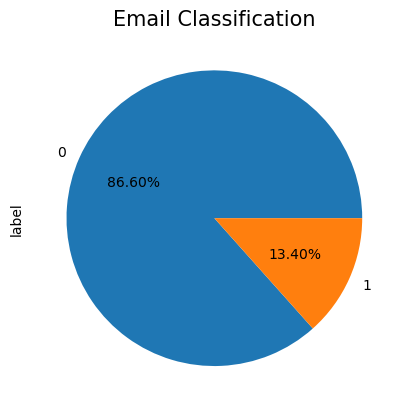

In [18]:
df['label'].value_counts().plot(kind='pie',autopct = '%1.2f%%')
plt.title('Email Classification', fontsize=15)
plt.show()

In [19]:
# ngrams

def ngram_extractor(data,ngram_range):
    tokens = word_tokenize(data)
    ngram = ngrams(tokens,ngram_range)#zip file
    ngram_list1 = []
    for ngram1 in ngram:
        ngram_list1.append(' '.join(ngram1))
    return ngram_list1


In [20]:
list_unigrams = df.normalized_sms.apply(lambda x : ngram_extractor(x,1))
list_unigrams

0       [jurong, point, crazy, available, bugis, great...
1                                 [lar, joking, wif, oni]
2       [free, entry, wkly, comp, win, cup, final, tkt...
3                    [dun, say, early, hor, already, say]
4        [nah, not, think, go, usf, life, around, though]
                              ...                        
5569    [time, tried, contact, pound, prize, claim, ea...
5570                             [going, esplanade, home]
5571                             [pity, mood, suggestion]
5572    [guy, bitching, acted, like, would, interested...
5573                                   [rofl, true, name]
Name: normalized_sms, Length: 5574, dtype: object

In [21]:
final_unigram = []
for unigram in list_unigrams:
    final_unigram.extend(unigram)
    
cnt_df = pd.DataFrame(Counter(final_unigram).most_common(30))
cnt_df

,0,1
0,not,1169
1,call,605
2,get,397
3,know,307
4,free,278
5,want,253
6,love,253
7,come,253
8,got,252
9,like,249


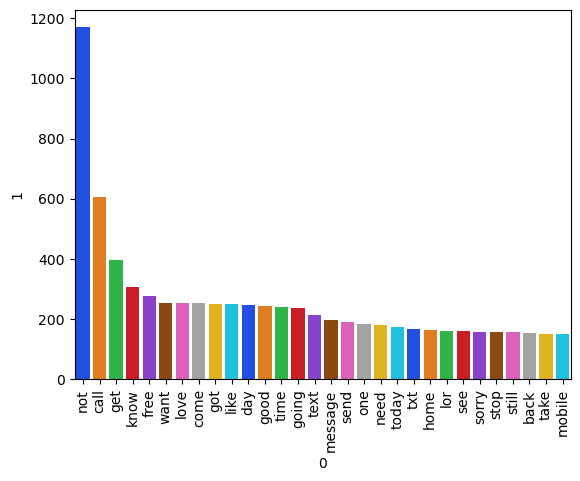

In [22]:
sns.barplot(data = cnt_df,x = cnt_df[0],y=cnt_df[1],palette='bright')
plt.xticks(rotation=90)
plt.show()

In [23]:
list_bigrams = df.normalized_sms.apply(lambda x : ngram_extractor(x,2))
list_bigrams

0       [jurong point, point crazy, crazy available, a...
1                       [lar joking, joking wif, wif oni]
2       [free entry, entry wkly, wkly comp, comp win, ...
3       [dun say, say early, early hor, hor already, a...
4       [nah not, not think, think go, go usf, usf lif...
                              ...                        
5569    [time tried, tried contact, contact pound, pou...
5570                    [going esplanade, esplanade home]
5571                         [pity mood, mood suggestion]
5572    [guy bitching, bitching acted, acted like, lik...
5573                               [rofl true, true name]
Name: normalized_sms, Length: 5574, dtype: object

In [24]:
final_unigram = []
for bigram in list_bigrams:
    final_unigram.extend(bigram)
    
cnt = Counter(final_unigram).most_common(30)
cnt

[('not know', 79),
 ('please call', 55),
 ('call later', 52),
 ('let know', 50),
 ('sorry call', 38),
 ('take care', 34),
 ('new year', 32),
 ('good morning', 32),
 ('customer service', 29),
 ('not get', 28),
 ('call landline', 24),
 ('free call', 23),
 ('guaranteed call', 23),
 ('prize guaranteed', 22),
 ('send stop', 22),
 ('pls send', 22),
 ('not sure', 21),
 ('every week', 21),
 ('good night', 20),
 ('chance win', 19),
 ('selected receive', 19),
 ('free text', 19),
 ('happy new', 19),
 ('await collection', 19),
 ('call claim', 18),
 ('not want', 18),
 ('urgent mobile', 18),
 ('wat time', 18),
 ('last night', 18),
 ('call land', 18)]

## Word cloud for spam messages

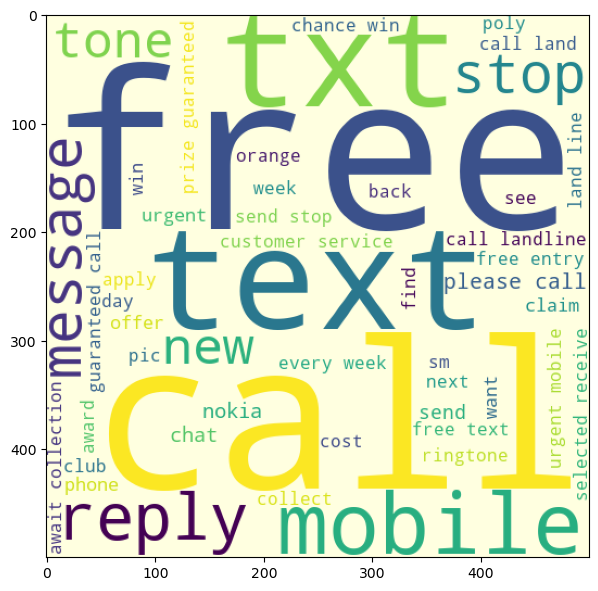

In [25]:
wc = WordCloud(width = 500,height= 500,min_font_size = 15, background_color = 'lightyellow')
spam_wc = wc.generate(df[df['label'] == 1]['normalized_sms'].str.cat(sep = " "))
plt.figure(figsize = (7,12))
plt.imshow(spam_wc)
plt.show()

## Word cloud for not spam messages

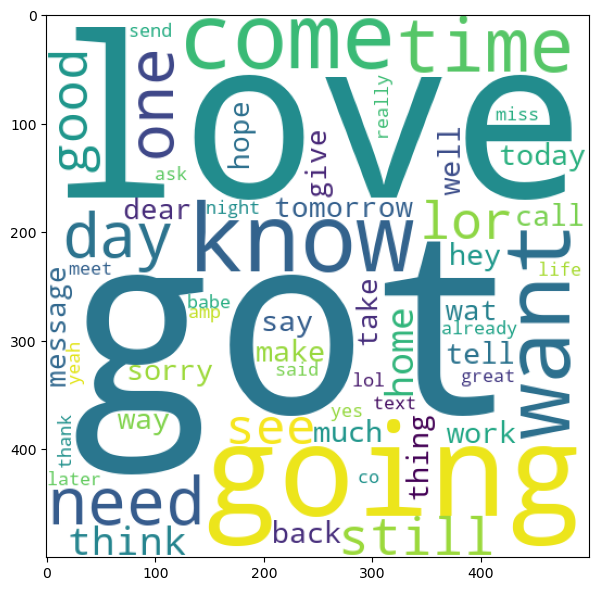

In [26]:
wc = WordCloud(width=500,height=500,min_font_size=15,background_color='white')
not_spam_wc = wc.generate(df[df['label']==0]['normalized_sms'].str.cat(sep=' '))
plt.figure(figsize=(7,12))
plt.imshow(not_spam_wc)
plt.show()

## Find Top 30 Word of spam

In [27]:
spam_word_list = []
for sentense in df[df['label']==1]['normalized_sms'].to_list():
#     print(sentense)
     for word in sentense.split():
#         print(word)
         spam_word_list.append(word)

In [28]:
spam_word_list

['free',
 'entry',
 'wkly',
 'comp',
 'win',
 'cup',
 'final',
 'tkts',
 'may',
 'text',
 'receive',
 'entry',
 'question',
 'std',
 'txt',
 'rate',
 'apply',
 'freemsg',
 'hey',
 'darling',
 'week',
 'word',
 'back',
 'would',
 'like',
 'fun',
 'still',
 'xxx',
 'std',
 'chgs',
 'send',
 'rcv',
 'winner',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'prize',
 'reward',
 'claim',
 'call',
 'claim',
 'code',
 'valid',
 'hour',
 'mobile',
 'month',
 'entitled',
 'update',
 'latest',
 'colour',
 'mobile',
 'camera',
 'free',
 'call',
 'mobile',
 'update',
 'free',
 'six',
 'chance',
 'win',
 'cash',
 'pound',
 'txt',
 'send',
 'cost',
 'tsandcs',
 'apply',
 'reply',
 'info',
 'urgent',
 'week',
 'free',
 'membership',
 'prize',
 'jackpot',
 'txt',
 'word',
 'claim',
 'lccltd',
 'pobox',
 'xxxmobilemovieclub',
 'use',
 'credit',
 'click',
 'wap',
 'link',
 'next',
 'txt',
 'message',
 'click',
 'http',
 'england',
 'macedonia',
 'not',
 'miss',
 'news',
 'txt',
 'national

In [29]:
word_df  = pd.DataFrame(Counter(spam_word_list).most_common(30))
word_df

,0,1
0,call,358
1,free,219
2,txt,156
3,text,138
4,mobile,135
5,stop,118
6,claim,115
7,reply,105
8,prize,94
9,get,84


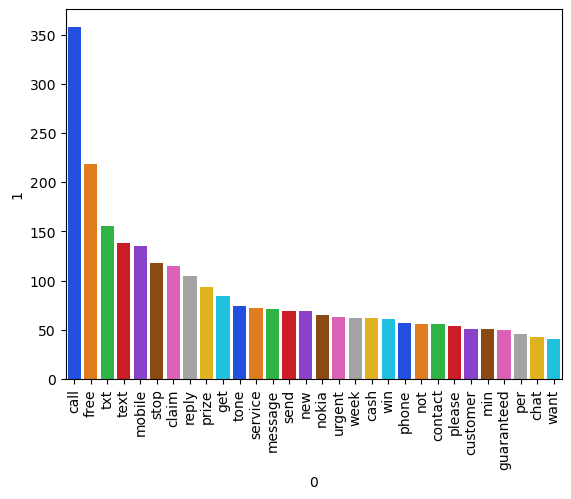

In [30]:
sns.barplot(data=word_df,x=word_df[0],y=word_df[1],palette='bright')
plt.xticks(rotation=90)
plt.show()

## Find top 30 word not spam

In [31]:
not_spam_word_list = []
for sentense in df[df['label']==0]['normalized_sms'].to_list():
    for word in sentense.split():
        not_spam_word_list.append(word)

In [32]:
word_df1 = pd.DataFrame(Counter(not_spam_word_list).most_common(30))
word_df1

,0,1
0,not,1113
1,get,313
2,know,281
3,come,248
4,call,247
5,got,245
6,love,238
7,like,236
8,going,234
9,good,232


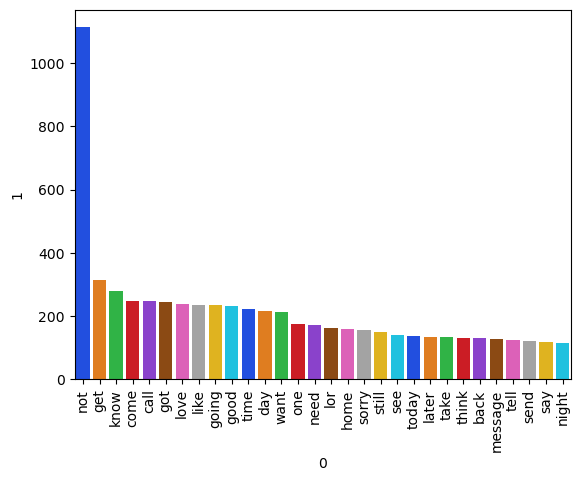

In [33]:
sns.barplot(data=word_df1,x=word_df1[0],y=word_df1[1],palette='bright')
plt.xticks(rotation=90)
plt.show()

## <h1 style="color:darkblue">Model Building

## Text Vectorization

### 1.Count_Vectorizer

In [34]:
count_vec = CountVectorizer()
bow = count_vec.fit_transform(clean_text_train).A
new_df = pd.DataFrame(bow,columns=count_vec.get_feature_names_out())
new_df

,aah,aaniye,aaooooright,aathi,abbey,abdomen,abeg,abel,aberdeen,abi,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### train_test_split

In [35]:
x = new_df
y = df['label']

In [36]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=2,test_size=0.2,stratify=y)
x_train.shape

(4459, 6497)

In [37]:
svm = SVC()
svm.fit(x_train,y_train)
svm

SVC()

In [38]:
def evaluation(model,ind_var,act):
    pred = model.predict(ind_var)
    
    acc_score = accuracy_score(act,pred)
    print('accuracy score',acc_score)
    
    con_mat = confusion_matrix(act,pred)
    print('confusion metrix \n',con_mat)
    
    cls_rep = classification_report(act,pred)
    print('classification report \n',cls_rep)
    
    
evaluation(svm,x_train,y_train)

accuracy score 0.9943933617403005
confusion metrix 
 [[3861    0]
 [  25  573]]
classification report 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3861
           1       1.00      0.96      0.98       598

    accuracy                           0.99      4459
   macro avg       1.00      0.98      0.99      4459
weighted avg       0.99      0.99      0.99      4459



In [39]:
evaluation(svm,x_test,y_test)

accuracy score 0.9739910313901345
confusion metrix 
 [[966   0]
 [ 29 120]]
classification report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [40]:
svm.predict(x_train[:1])[0]

0

In [41]:
def model_building(algo, x, y):
    model = algo
    model.fit(x,y)
    return model

In [42]:
models = [('Logistic_Regression',LogisticRegression()),('SVM',SVC()),('Naive_Bayes',MultinomialNB()),('Random_Forest',RandomForestClassifier()),('Decision_Tree',DecisionTreeClassifier())]

for name,model in models:
#     print(model)
    new_model = model_building(model,x_train,y_train)
    print(name,':')
    print()
    
    acc_rf = round(model.score(x_train, y_train) * 100, 2)
    print('train_accuracy :',acc_rf)
    acc_rf = round(model.score(x_test, y_test) * 100, 2)
    print('test_accuracy :',acc_rf)
    print()

    model_building(model,x_train,y_train)

Logistic_Regression :

train_accuracy : 99.33
test_accuracy : 97.67

SVM :

train_accuracy : 99.44
test_accuracy : 97.4

Naive_Bayes :

train_accuracy : 98.56
test_accuracy : 96.59

Random_Forest :

train_accuracy : 100.0
test_accuracy : 97.67

Decision_Tree :

train_accuracy : 100.0
test_accuracy : 96.05



## <h2 style="color:red">Conclusion

<h3 style="color:darkblue">In our evaluation of various classification algorithms, we observed the following key insights:

<b><p style='color:black'>1.Support Vector Classifier (SVC) and Logistic Regression demonstrated the highest accuracy, achieving training apprx. 99.4% and Testing is 97.58%. here both model gives a less variation.

2.Support Vector Classifier (SVC) achieved a perfect precision score, indicating zero false positives.

3.Additional models, including Random Forest,Naive Bayes,Decision Tree exhibited competitive performance, with accuracy scores ranging from 98.68% to 96.03%.

4.While accuracy is a crucial metric, other factors like computational efficiency and specific application requirements should be considered in the selection of the optimal model.

5.It is noteworthy that Naive Bayes achieved a flawless precision score, highlighting its ability to minimize false positives.

6.The Random Forest (RF) and Decision Tree models demonstrated flawless accuracy of 100% during the training phase. However, upon transitioning to the testing phase, there was some deviation in their performance.

7.Emphasizing the importance of a comprehensive model selection process, factors beyond accuracy, such as computational efficiency, should guide the final decision.
Prior to making a conclusive choice, it is advisable to undertake further model fine-tuning and validation to ensure optimal performance aligning with the specific needs of the application.

## Word2Vec

In [43]:
sent = clean_text_train.to_list()
splited_sent = [sen.split() for sen in sent]
splited_sent

[['jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'great',
  'world',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat'],
 ['lar', 'joking', 'wif', 'oni'],
 ['free',
  'entry',
  'wkly',
  'comp',
  'win',
  'cup',
  'final',
  'tkts',
  'may',
  'text',
  'receive',
  'entry',
  'question',
  'std',
  'txt',
  'rate',
  'apply'],
 ['dun', 'say', 'early', 'hor', 'already', 'say'],
 ['nah', 'not', 'think', 'go', 'usf', 'life', 'around', 'though'],
 ['freemsg',
  'hey',
  'darling',
  'week',
  'word',
  'back',
  'would',
  'like',
  'fun',
  'still',
  'xxx',
  'std',
  'chgs',
  'send',
  'rcv'],
 ['even', 'brother', 'not', 'like', 'speak', 'treat', 'like', 'aid', 'patent'],
 ['per',
  'request',
  'melle',
  'oru',
  'minnaminunginte',
  'nurungu',
  'vettam',
  'set',
  'callertune',
  'caller',
  'press',
  'copy',
  'friend',
  'callertune'],
 ['winner',
  'valued',
  'network',
  'customer',
  'selected',
  'receivea',
  'prize',
  'reward',
  'claim',
  'call',
  'cl

In [44]:
word2vec_model = Word2Vec(splited_sent,min_count=2,window=3)
word2vec_model.vector_size

100

In [55]:
word2vec_model.save("word2vec.model")

In [56]:
# document numerical format
def vectorizer(list_of_docs,model):
    feature = []
    for rew in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
#         print(rew)
        vectors = []
        for word in rew:
            try:
                word in model.wv
                vectors.append(model.wv[word])
                
            except KeyError:
                continue
                
        if vectors:
            vectors = np.asarray(vectors)
#             print(vectors)
            avg_vec = vectors.mean(axis=0)
            feature.append(avg_vec)
            
        else:
            feature.append(zero_vector)
            
    return feature 
            

In [57]:
vectorized_docs = vectorizer(splited_sent,word2vec_model)
vectorized_docs

[array([-1.47623807e-01,  1.28819555e-01,  3.26648908e-04,  5.05992100e-02,
         4.86197844e-02, -2.51852810e-01,  9.65606049e-02,  3.19525868e-01,
        -1.42069697e-01, -7.87189752e-02, -5.56379035e-02, -2.09812686e-01,
        -4.52588312e-02,  8.10556635e-02,  5.26967347e-02, -8.71612057e-02,
         3.87737639e-02, -1.83697388e-01, -6.57276213e-02, -3.17177474e-01,
         1.09291717e-01,  5.52146547e-02,  1.04039349e-01, -1.26993865e-01,
        -4.58155908e-02,  3.41297453e-03, -1.42799392e-01, -9.61367115e-02,
        -1.74551725e-01, -2.70767398e-02,  1.95011929e-01,  7.17955083e-02,
         6.70063198e-02, -9.08118114e-02, -4.11059074e-02,  1.80899709e-01,
         3.35854664e-02, -1.17512941e-01, -7.91099444e-02, -3.33887249e-01,
         2.50886343e-02, -1.14189543e-01, -5.89586087e-02,  1.77467056e-02,
         1.09836400e-01, -3.93007323e-02, -1.01358891e-01, -3.00611858e-03,
         8.81073624e-02,  1.79452419e-01,  5.09484783e-02, -1.16957605e-01,
        -6.8

In [58]:
len(vectorized_docs)

5574

In [59]:
x_embed = np.array(vectorized_docs)
x_embed

array([[-0.14762381,  0.12881956,  0.00032665, ..., -0.20874651,
         0.03576739, -0.02796218],
       [-0.07839392,  0.06827677, -0.00064408, ..., -0.11088966,
         0.0217525 , -0.01112369],
       [-0.16329814,  0.14435755, -0.00210724, ..., -0.22819372,
         0.03000493, -0.02750845],
       ...,
       [-0.02461859,  0.02907114, -0.0016059 , ..., -0.04213338,
         0.00515031, -0.00091724],
       [-0.18949978,  0.16880387, -0.00274763, ..., -0.26799574,
         0.04287644, -0.03491774],
       [-0.11666701,  0.10042452, -0.00171045, ..., -0.16623777,
         0.0200508 , -0.02900452]])

In [60]:
word2vec_df = pd.DataFrame(x_embed)
word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.147624,0.128820,0.000327,0.050599,0.048620,-0.251853,0.096561,0.319526,-0.142070,-0.078719,...,0.183862,0.139263,0.016373,0.065146,0.309380,0.153905,0.057062,-0.208747,0.035767,-0.027962
1,-0.078394,0.068277,-0.000644,0.026755,0.028549,-0.139296,0.052996,0.168861,-0.076442,-0.040968,...,0.098274,0.078808,0.006454,0.033197,0.163198,0.078953,0.028651,-0.110890,0.021752,-0.011124
2,-0.163298,0.144358,-0.002107,0.059458,0.055652,-0.278435,0.107413,0.362391,-0.152187,-0.087829,...,0.203816,0.157206,0.025029,0.076413,0.339002,0.166797,0.059906,-0.228194,0.030005,-0.027508
3,-0.208346,0.185197,-0.005475,0.070728,0.070150,-0.366657,0.136207,0.459144,-0.198614,-0.112566,...,0.265301,0.198382,0.021292,0.097007,0.437628,0.217414,0.075673,-0.301087,0.044486,-0.043070
4,-0.190686,0.170004,0.000735,0.071190,0.059269,-0.331353,0.127786,0.425081,-0.188515,-0.106592,...,0.250943,0.184130,0.021776,0.087479,0.407567,0.200059,0.064433,-0.279716,0.046975,-0.042011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,-0.225711,0.204200,-0.002595,0.079066,0.078288,-0.381693,0.144728,0.497083,-0.216440,-0.123877,...,0.275532,0.212957,0.031697,0.096604,0.468278,0.228176,0.089048,-0.317058,0.045965,-0.043712
5570,-0.214919,0.196838,0.002597,0.082678,0.064542,-0.375658,0.137786,0.472571,-0.211285,-0.116851,...,0.284757,0.209399,0.026562,0.090579,0.447657,0.227770,0.080015,-0.306537,0.048787,-0.036071
5571,-0.024619,0.029071,-0.001606,0.012898,0.004966,-0.044062,0.015312,0.063080,-0.025994,-0.014336,...,0.041963,0.023215,0.004287,0.009371,0.057753,0.026240,0.001538,-0.042133,0.005150,-0.000917
5572,-0.189500,0.168804,-0.002748,0.070683,0.061964,-0.324766,0.125819,0.415969,-0.183395,-0.102769,...,0.239263,0.182830,0.026169,0.085633,0.398743,0.196320,0.068695,-0.267996,0.042876,-0.034918


### Train test split for word2vec

In [ ]:
x = word2vec_df
y = df['label']

In [62]:
x_train1,x_test1,y_train1,y_test1 = train_test_split(x,y,random_state=3,test_size=0.2,stratify=y)
x_train1.shape

(4459, 6497)

In [64]:
log_reg1 = LogisticRegression()
log_reg1.fit(x_train1,y_train1)

LogisticRegression()

In [65]:
def evaluation(model,ind_var,act):
    pred = model.predict(ind_var)
    
    acc_score = accuracy_score(act,pred)
    print('accuracy score',acc_score)
    
    con_mat = confusion_matrix(act,pred)
    print('confusion metrix \n',con_mat)
    
    cls_rep = classification_report(act,pred)
    print('classification report \n',cls_rep)
    
    
evaluation(svm,x_train1,y_train1)

accuracy score 0.989683785602153
confusion metrix 
 [[3861    0]
 [  46  552]]
classification report 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3861
           1       1.00      0.92      0.96       598

    accuracy                           0.99      4459
   macro avg       0.99      0.96      0.98      4459
weighted avg       0.99      0.99      0.99      4459



In [66]:
evaluation(svm,x_test1,y_test1)

accuracy score 0.9928251121076234
confusion metrix 
 [[966   0]
 [  8 141]]
classification report 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       1.00      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [63]:
models = [('Logistic_Regression',LogisticRegression()),('SVM',SVC()),('Naive_Bayes',MultinomialNB()),('Random_Forest',RandomForestClassifier()),('Decision_Tree',DecisionTreeClassifier())]

for name,model in models:
#     print(model)
    new_model = model_building(model,x_train1,y_train1)
    print(name,':')
    print()
    
    acc_rf = round(model.score(x_train1, y_train1) * 100, 2)
    print('train_accuracy :',acc_rf)
    acc_rf = round(model.score(x_test1, y_test1) * 100, 2)
    print('test_accuracy :',acc_rf)
    print()

    model_building(model,x_train1,y_train1)

Logistic_Regression :

train_accuracy : 99.46
test_accuracy : 97.94

SVM :

train_accuracy : 99.48
test_accuracy : 97.22

Naive_Bayes :

train_accuracy : 98.74
test_accuracy : 96.68

Random_Forest :

train_accuracy : 99.98
test_accuracy : 97.76

Decision_Tree :

train_accuracy : 99.98
test_accuracy : 96.41



<h2 style="color:red">Conclusion

<h3 style="color:darkblue">In our evaluation of various classification algorithms, we observed the following key insights:

<b><p style='color:black'>1.Support Vector Classifier (SVC) and Logistic Regression demonstrated the highest accuracy, achieving training apprx. 99.4% and Testing is 99.58%. here both model gives a less variation.

2.Support Vector Classifier (SVC) achieved a perfect precision score, indicating zero false positives.

3.Additional models, including Random Forest,Naive Bayes,Decision Tree exhibited competitive performance, with accuracy scores ranging from 98.68% to 96.03%.

4.While accuracy is a crucial metric, other factors like computational efficiency and specific application requirements should be considered in the selection of the optimal model.

5.It is noteworthy that Naive Bayes achieved a flawless precision score, highlighting its ability to minimize false positives.

6.The Random Forest (RF) and Decision Tree models demonstrated flawless accuracy of 100% during the training phase. However, upon transitioning to the testing phase, there was some deviation in their performance.

7.Emphasizing the importance of a comprehensive model selection process, factors beyond accuracy, such as computational efficiency, should guide the final decision.
Prior to making a conclusive choice, it is advisable to undertake further model fine-tuning and validation to ensure optimal performance aligning with the specific needs of the application.